<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Rohan Tiwari</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Monday, April 18, 2022, 11:59 PM**


* Total marks: 46


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [7 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [ ]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [ ]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [ ]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [ ]:
X_raw.shape

(16512, 9)

In [ ]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [ ]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.


**[Add your solution here]**

1. remove the text attributed "ocean_proximity" before fitting SimpleImputer as median calculation would not work for text attribute
2. Train a SimpleImputer on the housing training data using fit method.
3. Tranform the training data (replace missing values with corresponding median of each feature) using transform method.
4. Convert result back to pandas dataframe.  

In [ ]:
from sklearn.impute import SimpleImputer

housing_num = X_raw.drop("ocean_proximity", axis=1)

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**[Add your solution here]**

"ocean_proximity" is the text and categorial attribute to preprocess. 
We first look at a sample of data.

In [ ]:
housing_cat = X_raw[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


We can convert the above categories into numbers by using OrdinalEncoder.
OrdinalEncoder gives a list of categories in a 1D array (for each categorial attribute). In our case, we can a single 1D array as there is only one categorical attribute. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g.,for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).The new attributes are sometimes called dummy attributes (From textbook). 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Note that the above output is a SciPy sparse matrix instead of a NumPy array. This is very useful when you have categorial attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the non-zero elements. We can convert it to a dense NumPy array as follows.

In [ ]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Let us check the list of categories.

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## (c) Feature scaling [2 marks]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

**Task:** Read the subsection "Feature Scaling" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.MinMaxScaler` class and `sklearn.preprocessing.StandardScaler` class to scale the numerical features using min-max scaling and standardization.


**[Add your solution here]**

Let us try MinMaxScalar first that shifts values so that they end up ranging from 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scalar = MinMaxScaler()
minmax_housing = minmax_scalar.fit_transform(housing_tr)
X = pd.DataFrame(minmax_housing, columns=housing_tr.columns,index=housing_tr.index)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,0.287849,0.635494,0.549020,0.098362,0.128061,0.062614,0.131441,0.115426
15502,0.709163,0.058448,0.117647,0.135168,0.137403,0.056392,0.143017,0.402574
2908,0.528884,0.300744,0.843137,0.041003,0.049613,0.018610,0.055639,0.163798
14053,0.719124,0.022317,0.450980,0.047591,0.083280,0.025085,0.089806,0.119067
20496,0.562749,0.184910,0.509804,0.089790,0.103737,0.051403,0.107916,0.275617


Let us try StandardScalar which first subtracts the mean value and then divides it by standard deviation so the resulting distribution has unit variance and standardized values always have a zero mean. 

In [ ]:
from sklearn.preprocessing import StandardScaler

standard_scalar = StandardScaler()
standard_housing = standard_scalar.fit_transform(housing_tr)
X = pd.DataFrame(standard_housing, columns=housing_tr.columns,index=housing_tr.index)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752


## (d) Transformation pipelines [2 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `Pipeline` class provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then, create one pipeline that applies the transformations on part (a), (b) (use one-hot encoding), and (c) (use standardization) to the "raw" features `X_raw`. Call your transformed data `X`.

**[Add your solution here]**

We first create a numerical pipeline and then apply the ColumnTransformer to handle all transformations for columns

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('std_scalar', StandardScaler()),
])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                ("num", num_pipeline, num_attribs),
                                ("cat", OneHotEncoder(), cat_attribs),
])

X = full_pipeline.fit_transform(X_raw)
X = pd.DataFrame(X, columns=num_attribs+['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], index=housing_num.index)
X.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(d) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**[Add your solution here]**

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

some_data = X.iloc[:10]
some_labels = y.iloc[:10]
print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841 208983.6813477  375046.02067267 270259.898592
 153462.62515736  12077.73402934]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0]


## (b) RMSE and MAE  [2 marks]

We can measure the out-of-sample performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**[Add your solution here]**

First let us try RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(X)
lin_mse = mean_squared_error(y, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

Now let us try MAE

In [ ]:
from sklearn.metrics import mean_absolute_error
housing_predictions = lin_reg.predict(X)
lin_mae = mean_absolute_error(y, housing_predictions)
lin_mae

49905.329442715316

## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**[Add your solution here]**

In [ ]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X,y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494764
Standard deviation: 2372.070791055919


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [ ]:
dt_reg.predict(X.iloc[:10,])

array([ 72100., 279600.,  82700., 112500., 238300., 165700., 412300.,
       349600., 181300., 500001.])

The following code does the same for the random forest model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
rf_reg.predict(X.iloc[:10,])

array([ 81652.52309416, 312816.43220775, 103956.26879436, 145669.10673902,
       254963.91541844, 223471.15507845, 359454.5338993 , 261250.07064825,
       178062.03642388, 152509.12871198])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**[Add your solution here]**

RMSE for decision tree (in-sample)

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = dt_reg.predict(X)
dt_mse = mean_squared_error(y, housing_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_rmse

0.0

RMSE for random forest (in-sample)

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = rf_reg.predict(X)
rf_mse = mean_squared_error(y, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

66750.70697525762

out-of-sample performance of decision tree 

In [ ]:
from sklearn.model_selection import cross_val_score
dt_scores = cross_val_score(dt_reg, X,y, scoring="neg_mean_squared_error", cv=10)
dt_rmse_scores = np.sqrt(-dt_scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(dt_rmse_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


out-of-sample performance of random forest

In [ ]:
from sklearn.model_selection import cross_val_score
rf_scores = cross_val_score(rf_reg, X,y, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rf_rmse_scores)

Scores: [70666.17468232 65975.4104431  63466.98553521 71762.08084765
 65644.92773928 70198.63516218 69549.01504688 68795.8612658
 65340.03824595 68660.17724972]
Mean: 68005.93062180877
Standard deviation: 2585.2080431468353


Decision tree gives best in-sample performance and random forest has best out-of-sample performance.


## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely `bootstrap`, `n_estimators`, and `max_depth`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `bootstrap` over the values `True`, `False`; `n_estimators` over the values 50, 100, 200; and `max_depth` over the values 5, 20, 40. Use 4-fold cross-validation with RMSE when searching for the hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search over the same ranges with 18 parameter settings sampled, that is `bootstrap` is `True` or `False` with equal probability, `n_estimators` is a uniform random integer between 50 and 200, `max_depth` is a uniform random integer between 5 and 40. `RandomizedSearchCV` must include the argument `random_state=42`.

In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**[Add your solution here]**

Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators':[50,100,200], 'bootstrap':[True, False], 'max_depth':[5,20,40]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [5, 20, 40],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=40, n_estimators=200, random_state=42)

In [ ]:
np.sqrt(-grid_search.best_score_)

50271.12629517273

Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = [
              {'n_estimators':randint(low=50, high=200), 'bootstrap':[True, False], 'max_depth':randint(low=5, high=40)}
]
forest_reg = RandomForestRegressor(random_state=42)
rd_search = RandomizedSearchCV(forest_reg, param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True, n_iter=18, random_state=42,n_jobs=-1)
rd_search.fit(X,y)

RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=18, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1a682791d0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1a68279110>}],
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
rd_search.best_params_

{'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}

In [ ]:
rd_search.best_estimator_

RandomForestRegressor(max_depth=28, n_estimators=166, random_state=42)

In [ ]:
np.sqrt(-rd_search.best_score_)

50273.28602841223

Grid Search is giving lower RMSE so the best hyperparameter values come from Grid Search and they are:
{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}




## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**[Add your solution here]**

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared, 
                               columns=num_attribs+['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47074.669205115606

# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**[Add your solution here]**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)


LinearRegression()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('polynomial', PolynomialFeatures(degree=3,include_bias=False)),
                         ('std_scalar', StandardScaler()),
])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                ("num", num_pipeline, num_attribs),
                                ("cat", OneHotEncoder(), cat_attribs),
])

X_ridge = full_pipeline.fit_transform(X_raw)
X_ridge = pd.DataFrame(X_ridge)

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_ridge,y)


Ridge(alpha=1, solver='cholesky')

## (b) Learning curves [4 marks]

Obtain learning curves for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither. When plotting the learning curve, use the function `train_test_split` with the argument `random_state=10` to create a validation set from a random 20% split of the test set. Instead of adding 1 instance at a time in the learning curve, add 1000 instances at a time.

**[Add your solution here]**

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train), 1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)

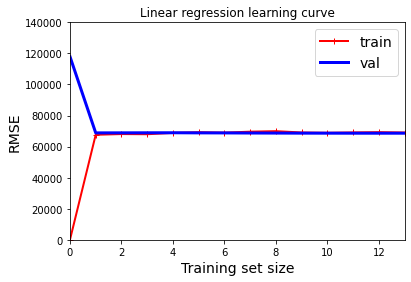

In [ ]:
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 13, 0, 140000])  # not shown in the book
plt.title("Linear regression learning curve")                       
plt.show()     

When the training set size is very low, the RMSE on training data is also very low (curve starts at 0). When more and  more instances are added to the training set, the RME on training data goes up but then reaches a plateau which means adding more instances does not make the error better or worse.

When the training set size is very low, the validation error is high but then it gradually goes down as more training instances are added. It also plateaus after a while which means adding more and more instances does not make the error better or worse. 

There is hardly any gap between the curves (maybe no gap) after we have added a few training instances. 

This means that a straight line does not a good job here and **the model is underfitting**.  (Referred concepts from textbook).

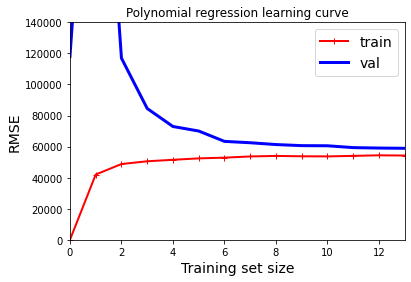

In [ ]:
plot_learning_curves(poly_reg, X_poly, y)
plt.axis([0, 13, 0, 140000])  # not shown in the book
plt.title("Polynomial regression learning curve")                       
plt.show()     

There is a significant gap between the curves. The model is performing significantly better on the training data than on the validation data. **This indicates an overfitting model**.  (Referred concepts from textbook). 

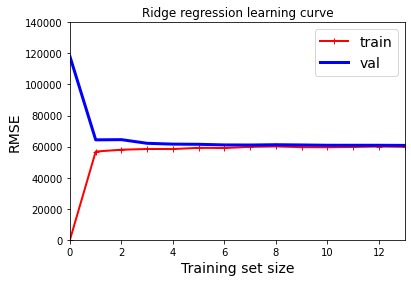

In [ ]:
plot_learning_curves(ridge_reg, X_ridge, y)
plt.axis([0, 13, 0, 140000])  # not shown in the book
plt.title("Ridge regression learning curve")                       
plt.show()     

Gap between the curves reduces as more training instances are added. The error is almost as low as what we see for polynomial regression. The curves coincide when more training instances are added indicating that **model is neither underfitting nor overfitting.**

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/90503805/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

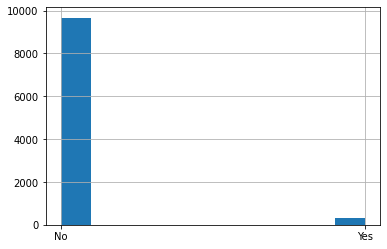

In [4]:
import os
import numpy as np
import pandas as pd
data = pd.read_csv("Default.csv")
data['default'].hist()

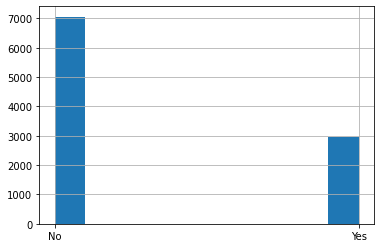

In [5]:
data['student'].hist()

**[Add your solution here]**

The below code makes sure that the ratio of student=yes and student=no is same as the original data.

In [6]:
from sklearn.model_selection import train_test_split

data_strat_train_set, data_strat_test_set = train_test_split(data, test_size=0.2, random_state=42)

X_raw = data_strat_train_set.drop("default", axis=1)
y = data_strat_train_set["default"].copy()
y_Yes = (y == 'Yes')

X_raw.head()

,student,balance,income
9254,No,1018.568130,34103.879520
1561,No,62.170050,28660.747508
1670,No,1046.743543,40822.447413
6087,No,763.735280,44125.718725
6669,Yes,697.248633,25730.917583


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**[Add your solution here]**

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
                         ('std_scalar', StandardScaler()),
])

num_attribs = ["balance", "income"]
cat_attribs = ["student"]

full_pipeline = ColumnTransformer([
                                ("num", num_pipeline, num_attribs),
                                ("cat", OneHotEncoder(), cat_attribs),
])
X_Raw_num = X_raw.drop("student", axis=1)

X = full_pipeline.fit_transform(X_raw)
X = pd.DataFrame(X, columns=num_attribs+['NO', 'YES'], index=X_Raw_num.index)
X.head()

,balance,income,NO,YES
9254,0.381082,0.037308,1.0,0.0
1561,-1.591774,-0.370099,1.0,0.0
1670,0.439202,0.540178,1.0,0.0
6087,-0.144587,0.787420,1.0,0.0
6669,-0.281735,-0.589390,0.0,1.0


## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC.

**[Add your solution here]**

In [8]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X,y_Yes) # maybe remove.

LogisticRegression(random_state=42)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X,y_Yes)

SGDClassifier(random_state=42)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)



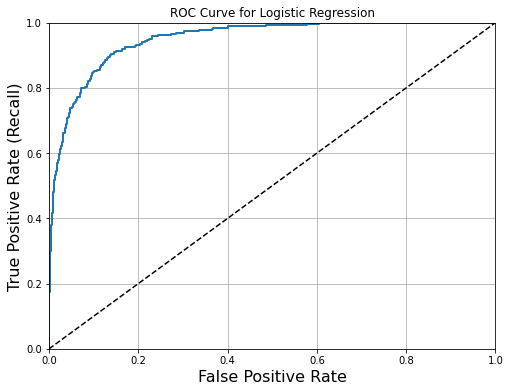

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
y_score_logistic_regression = cross_val_predict(log_reg, X, y_Yes, cv=10,method="decision_function")       #this is the score
fpr, tpr, thresholds = roc_curve(y_Yes, y_score_logistic_regression)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Logistic Regression')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_Yes, y_score_logistic_regression)

0.9501670662154117

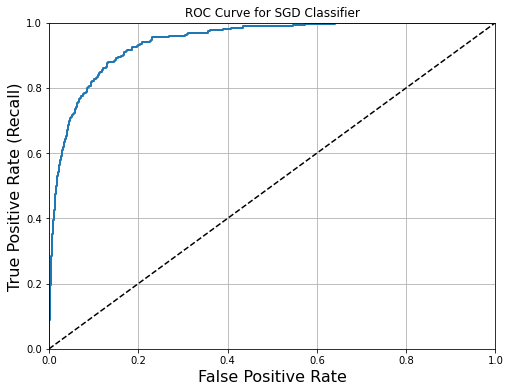

In [13]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
y_score_sgd_clf = cross_val_predict(sgd_clf, X, y_Yes, cv=10,method="decision_function")       #this is the score
fpr, tpr, thresholds = roc_curve(y_Yes, y_score_sgd_clf)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for SGD Classifier')
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_Yes, y_score_sgd_clf)

0.9433360557488014

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 80%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve an 80% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-10, 10, 0, 1])             # Not shown

**[Add your solution here]**

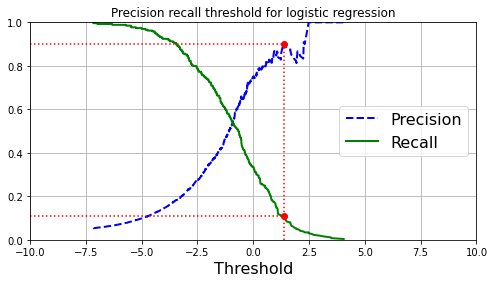

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_logistic_regression)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-10, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-10, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
plt.title("Precision recall threshold for logistic regression")                             # Not shown
plt.show()

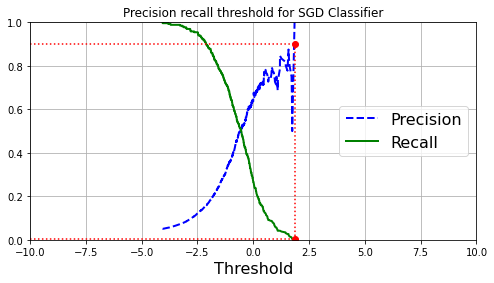

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_sgd_clf)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-10, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-10, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.title("Precision recall threshold for SGD Classifier")  
plt.show()

80% recall with logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_logistic_regression)

threshold_80_recall = thresholds[np.argmax(recalls >= 0.8)]
print("Threshold:", threshold_80_recall)

y_train_pred_80 = (y_score_logistic_regression >= threshold_80_recall)

print("Precision:", precision_score(y_Yes,y_train_pred_80))

Threshold: -7.168864964582789
Precision: 0.05340886101557758


80% recall with SGD Classifier

In [19]:
from sklearn.metrics import precision_score
from sklearn.linear_model import SGDClassifier

precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_sgd_clf)

threshold_80_recall = thresholds[np.argmax(recalls >= 0.8)]
print("Threshold:", threshold_80_recall)

y_train_pred_80 = (y_score_sgd_clf >= threshold_80_recall)

print("Precision:", precision_score(y_Yes,y_train_pred_80))

Threshold: -4.065059846392796
Precision: 0.050555342780543855


80% recall with Logistic regression and class_weight = "balanced"




In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

log_reg_b = LogisticRegression(random_state=42, class_weight="balanced")
log_reg_b.fit(X,y_Yes)

y_score_logistic_regression_b = cross_val_predict(log_reg_b, X, y_Yes, cv=10,method="decision_function")       #this is the score

precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_logistic_regression_b)

threshold_80_recall = thresholds[np.argmax(recalls >= 0.8)]
print("Threshold:", threshold_80_recall)

y_train_pred_80 = (y_score_logistic_regression_b >= threshold_80_recall)

print("Precision:", precision_score(y_Yes,y_train_pred_80))

Threshold: -3.7529438988460786
Precision: 0.052810562112422486


80% recall with SGD Classifier and class_weight = "balanced"


In [21]:
from sklearn.metrics import precision_score
from sklearn.linear_model import SGDClassifier

sgd_clf_b = SGDClassifier(random_state=42, class_weight="balanced")
sgd_clf_b.fit(X,y_Yes)

y_score_sgd_clf_b = cross_val_predict(sgd_clf_b, X, y_Yes, cv=10,method="decision_function")       #this is the score

precisions, recalls, thresholds = precision_recall_curve(y_Yes, y_score_sgd_clf_b)

threshold_80_recall = thresholds[np.argmax(recalls >= 0.8)]
print("Threshold:", threshold_80_recall)

y_train_pred_80 = (y_score_sgd_clf_b >= threshold_80_recall)

print("Precision:", precision_score(y_Yes,y_train_pred_80))

Threshold: -5.4512569350550635
Precision: 0.04080370942812983


Logistic regression without class_weight = "balanced" has the 
best precision.

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**[Add your solution here]**

Best Classifier: Logistic Regression without class_weight="balanced"

In [22]:
X_test = data_strat_test_set.drop("default", axis=1)
y = data_strat_test_set["default"].copy()
y_test_Yes = (y == 'Yes')
X_test_num = X_test.drop("student", axis=1)

X_test = full_pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns=num_attribs+['NO', 'YES'])

X_test.head()

,balance,income,NO,YES
0,1.241465,-0.157056,1.0,0.0
1,-0.127973,0.638724,1.0,0.0
2,-1.720019,-0.882921,1.0,0.0
3,-1.485744,-0.059998,1.0,0.0
4,1.081535,1.219882,1.0,0.0


In [23]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X,y_Yes)
y_score = log_reg.decision_function(X_test)
threshold = -7.168864964582789
y_pred = (y_score > threshold)

#y_pred = log_reg.predict(X_test)

Accuracy

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


#cross_val_score(log_reg, X_test, y_test_Yes, cv=10, scoring = "accuracy")   
accuracy_score(y_test_Yes, y_pred)

0.4075

Precision

In [25]:
from sklearn.metrics import precision_score

precision_score(y_test_Yes,y_pred)

0.05502392344497608

Recall

In [26]:
from sklearn.metrics import recall_score

recall_score(y_test_Yes,y_pred)

1.0

ROC Curve

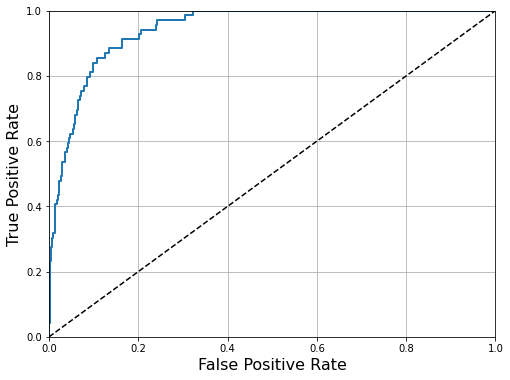

In [27]:
from sklearn.metrics import roc_curve

y_score = log_reg.decision_function(X_test)  #cross_val_predict(log_reg, X_test, y_test_Yes, cv=10,method="decision_function")
fpr, tpr, thresholds = roc_curve(y_test_Yes, y_score)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.grid(True)
plt.show()

ROC AUC 

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_Yes, y_score)

0.9435375528186192